In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
import ipywidgets as widgets
from IPython.display import display
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
%matplotlib inline

sns.set_style("whitegrid")

In [34]:
data_path = r"C:\Users\HP\OneDrive\Documents\Capstone_Project\data\blast_data_final.csv"

data = pd.read_csv(data_path, encoding='cp1251')

print("Размер датасета:", data.shape)
print("Столбцы:", data.columns.tolist())
print("\nПервые 5 строк:\n", data.head())
print("\nПропуски:\n", data.isnull().sum())

data.fillna(data.median(numeric_only=True), inplace=True)
print("\nПропуски после обработки:\n", data.isnull().sum())

data.rename(columns={
    'POWDER_FACTOR': 'NUM_POWDER_FACTOR',
    'BURDEN': 'NUM_BURDEN',
    'SPACING': 'NUM_SPACING'
}, inplace=True)

Размер датасета: (500, 48)
Столбцы: ['DATE', 'BLAST_ID', 'LOCATION', 'P20', 'NUM_POWDER_FACTOR', 'NUM_BURDEN', 'NUM_SPACING', 'HOLE_DIAMETER', 'UCS', 'ROCK_DENSITY', 'P90', 'Cu', 'Au', 'ROCK_TYPE', 'EXPLOSIVE_TYPE', 'BLAST_PATTERN', 'BURDEN_SPACING_RATIO', 'ENERGY_INDEX', 'UCS_LOG', 'FRAGMENTATION_INDEX', 'PARAM_21', 'PARAM_22', 'PARAM_23', 'PARAM_24', 'PARAM_25', 'PARAM_26', 'PARAM_27', 'PARAM_28', 'PARAM_29', 'PARAM_30', 'PARAM_31', 'PARAM_32', 'PARAM_33', 'PARAM_34', 'PARAM_35', 'PARAM_36', 'PARAM_37', 'PARAM_38', 'PARAM_39', 'PARAM_40', 'PARAM_41', 'PARAM_42', 'PARAM_43', 'PARAM_44', 'PARAM_45', 'PARAM_46', 'PARAM_47', 'PARAM_48']

Первые 5 строк:
          DATE    BLAST_ID   LOCATION        P20  NUM_POWDER_FACTOR  \
0  2023-01-01  BLAST_0001      Южный  61.416422           0.769495   
1  2023-01-02  BLAST_0002   Западный  44.408199           1.005519   
2  2023-01-03  BLAST_0003  Восточный  38.636382           0.966304   
3  2023-01-04  BLAST_0004      Южный  80.654804           0

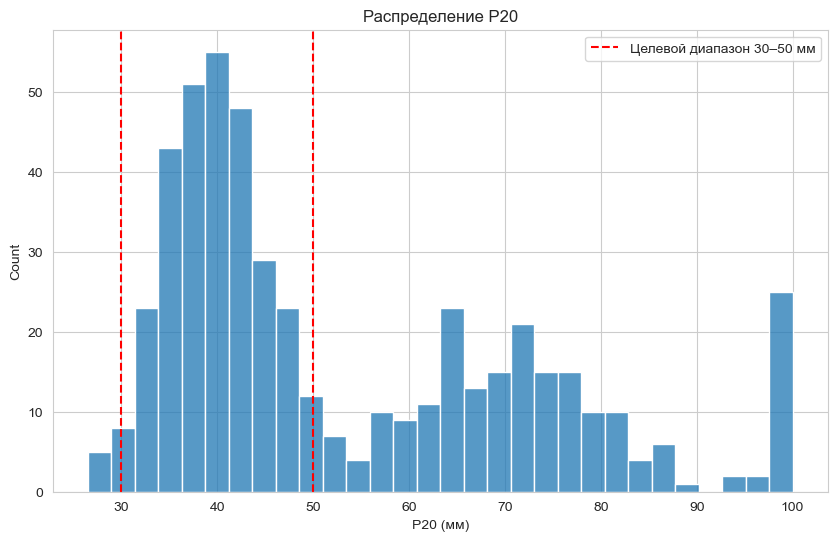

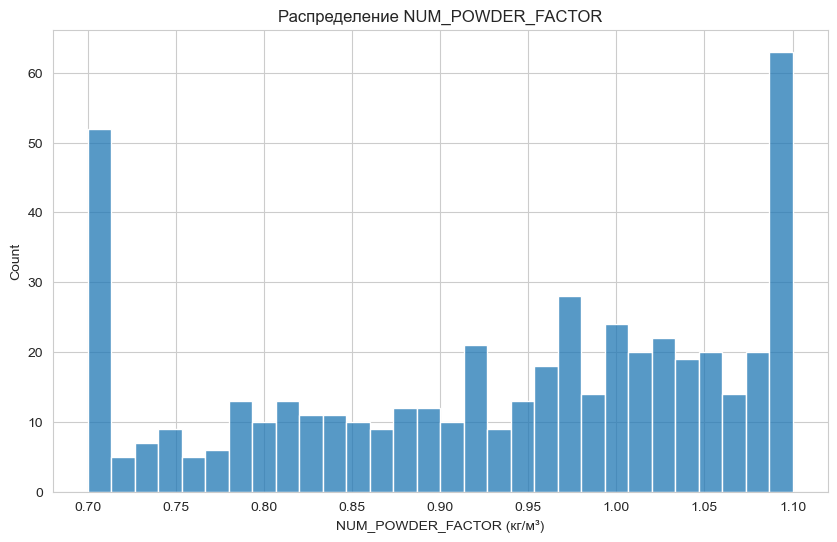

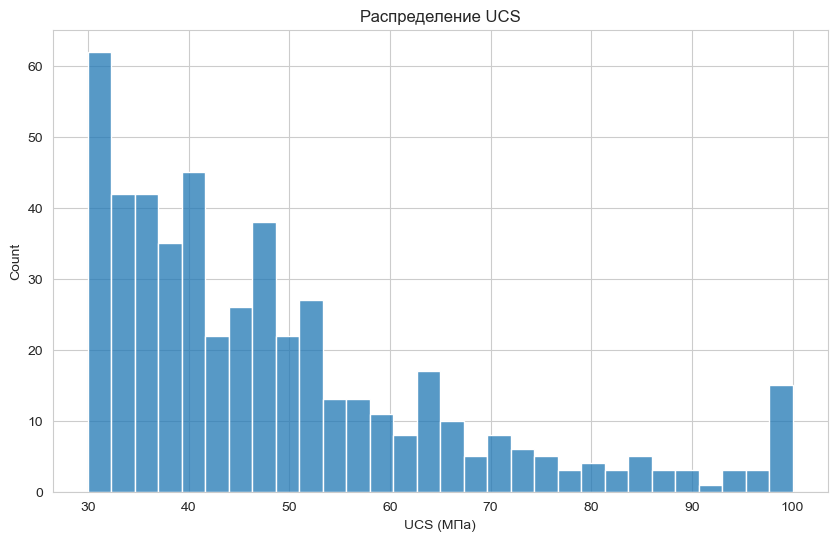

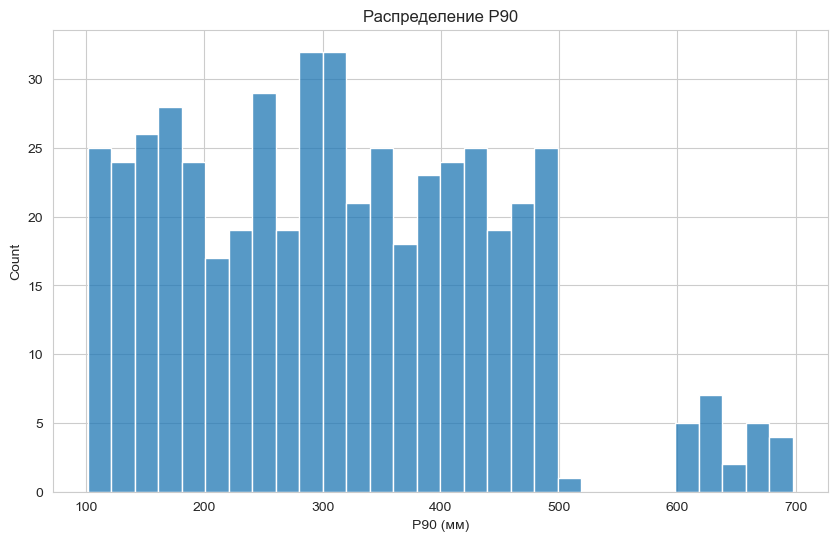

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(data['P20'], bins=30)
plt.axvline(30, color='red', linestyle='--', label='Целевой диапазон 30–50 мм')
plt.axvline(50, color='red', linestyle='--')
plt.title('Распределение P20')
plt.xlabel('P20 (мм)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['NUM_POWDER_FACTOR'], bins=30)
plt.title('Распределение NUM_POWDER_FACTOR')
plt.xlabel('NUM_POWDER_FACTOR (кг/м³)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['UCS'], bins=30)
plt.title('Распределение UCS')
plt.xlabel('UCS (МПа)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['P90'], bins=30)
plt.title('Распределение P90')
plt.xlabel('P90 (мм)')
plt.show()

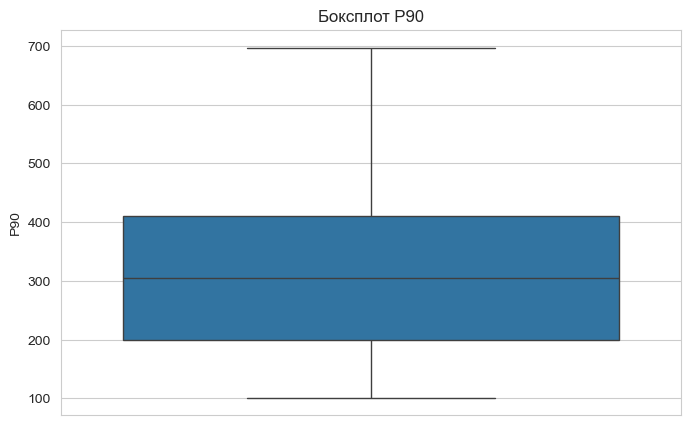

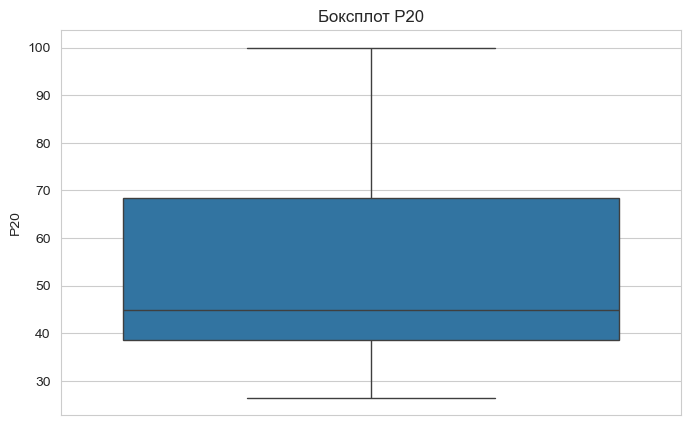

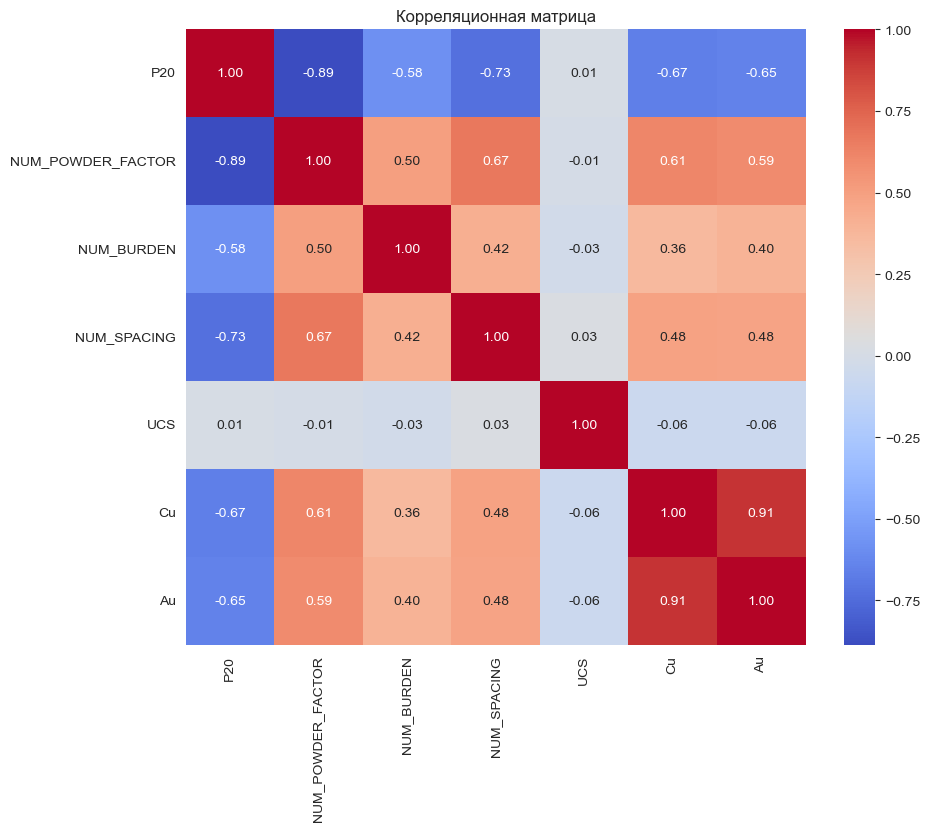

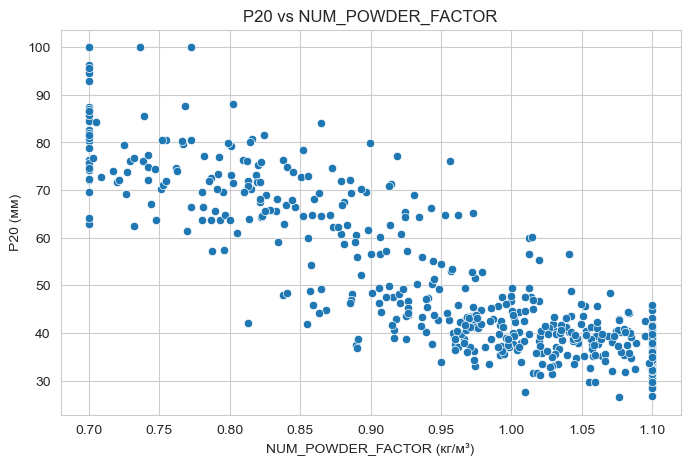

In [36]:
plt.figure(figsize=(8, 5))
sns.boxplot(data['P90'])
plt.title('Боксплот P90')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data['P20'])
plt.title('Боксплот P20')
plt.show()

corr_columns = ['P20', 'NUM_POWDER_FACTOR', 'NUM_BURDEN', 'NUM_SPACING', 'UCS', 'Cu', 'Au']
corr = data[corr_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='NUM_POWDER_FACTOR', y='P20', data=data)
plt.title('P20 vs NUM_POWDER_FACTOR')
plt.xlabel('NUM_POWDER_FACTOR (кг/м³)')
plt.ylabel('P20 (мм)')
plt.show()

In [37]:
data = data[(data['P20'] >= 10) & (data['P20'] <= 100)]
data = data[data['P90'] <= 600]
data = data[data['NUM_SPACING'] > 0] 
data = data[data['NUM_BURDEN'] > 0]  
print("Размер датасета после очистки:", data.shape)

from sklearn.utils import resample
target_data = data[(data['P20'] >= 30) & (data['P20'] <= 50)]
synthetic_data = resample(target_data, n_samples=1000, random_state=42)
data = pd.concat([data, synthetic_data]).reset_index(drop=True)
print("Размер датасета после добавления синтетических данных:", data.shape)

Размер датасета после очистки: (477, 48)
Размер датасета после добавления синтетических данных: (1477, 48)


In [38]:
data['UCS_log'] = np.log1p(data['UCS'])
data['BURDEN_SPACING_RATIO'] = data['NUM_BURDEN'] / data['NUM_SPACING'].replace(0, np.nan)

data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['BURDEN_SPACING_RATIO'])
print("\nНовые признаки:\n", data[['UCS', 'UCS_log', 'NUM_BURDEN', 'NUM_SPACING', 'BURDEN_SPACING_RATIO']].head())
print("\nПропуски в новых признаках:\n", data[['BURDEN_SPACING_RATIO']].isnull().sum())


Новые признаки:
          UCS   UCS_log  NUM_BURDEN  NUM_SPACING  BURDEN_SPACING_RATIO
0  52.529308  3.980229    6.000000     6.269422              0.957026
1  51.468239  3.960208    6.000000     6.477648              0.926262
2  31.453740  3.479816    6.000000     6.446056              0.930802
3  40.059111  3.715013    5.825353     6.107321              0.953831
4  34.012453  3.555704    5.706518     6.071611              0.939869

Пропуски в новых признаках:
 BURDEN_SPACING_RATIO    0
dtype: int64


In [39]:
features_to_scale = ['NUM_POWDER_FACTOR', 'UCS_log', 'NUM_BURDEN', 'NUM_SPACING', 'BURDEN_SPACING_RATIO']
print("\nПроверка на бесконечности перед нормализацией:\n", data[features_to_scale].apply(lambda x: np.isinf(x).sum()))

scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])
print("\nПосле нормализации:\n", data[features_to_scale].describe())


Проверка на бесконечности перед нормализацией:
 NUM_POWDER_FACTOR       0
UCS_log                 0
NUM_BURDEN              0
NUM_SPACING             0
BURDEN_SPACING_RATIO    0
dtype: int64

После нормализации:
        NUM_POWDER_FACTOR      UCS_log   NUM_BURDEN  NUM_SPACING  \
count        1477.000000  1477.000000  1477.000000  1477.000000   
mean            0.721423     0.345075     0.843772     0.844376   
std             0.249689     0.255959     0.177424     0.170350   
min             0.000000     0.000000     0.000000     0.000000   
25%             0.609864     0.129654     0.738695     0.743764   
50%             0.763503     0.300971     0.896426     0.891079   
75%             0.910402     0.487261     1.000000     1.000000   
max             1.000000     1.000000     1.000000     1.000000   

       BURDEN_SPACING_RATIO  
count           1477.000000  
mean               0.482172  
std                0.163593  
min                0.000000  
25%                0.383783  
50

In [40]:
X_vif = data[features_to_scale]
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna()
if len(X_vif) > 0:
    vif = pd.DataFrame()
    vif['Feature'] = X_vif.columns
    vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print("\nРезультаты VIF-анализа (все VIF < 5):\n", vif)
else:
    print("Ошибка: Нет данных для анализа VIF после очистки!")


Результаты VIF-анализа (все VIF < 5):
                 Feature         VIF
0     NUM_POWDER_FACTOR   14.997872
1               UCS_log    2.821176
2            NUM_BURDEN  129.564772
3           NUM_SPACING   46.560410
4  BURDEN_SPACING_RATIO   36.771586


In [41]:
features = ['NUM_POWDER_FACTOR', 'NUM_BURDEN', 'NUM_SPACING', 'UCS_log', 'BURDEN_SPACING_RATIO']
target = 'P20'
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nРазмеры выборок:\nTrain:", X_train.shape, "\nTest:", X_test.shape)


Размеры выборок:
Train: (1181, 5) 
Test: (296, 5)


In [42]:
rf = RandomForestRegressor(random_state=42)
params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
grid = GridSearchCV(rf, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print("\nЛучшие параметры:", grid.best_params_)

y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nМетрики модели:")
print(f"RMSE: {rmse:.2f} мм {'(цель достигнута)' if rmse < 5 else '(цель не достигнута)'}")
print(f"R²: {r2:.2f} {'(цель достигнута)' if r2 > 0.7 else '(цель не достигнута)'}")


Лучшие параметры: {'max_depth': None, 'n_estimators': 200}

Метрики модели:
RMSE: 3.59 мм (цель достигнута)
R²: 0.93 (цель достигнута)



Важность признаков:
                 Feature  Importance
0     NUM_POWDER_FACTOR    0.809997
2           NUM_SPACING    0.062908
1            NUM_BURDEN    0.055782
3               UCS_log    0.040027
4  BURDEN_SPACING_RATIO    0.031286


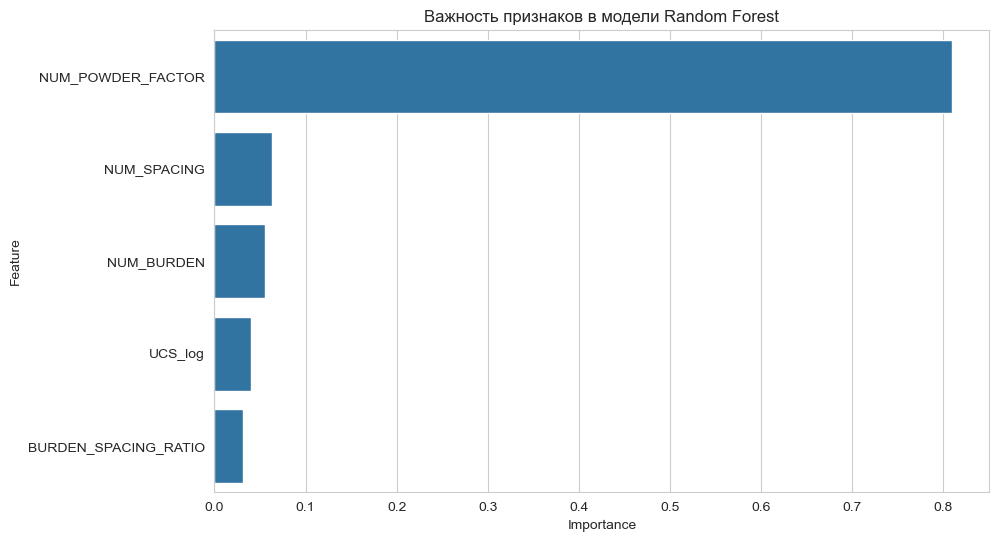

In [43]:
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nВажность признаков:\n", feature_importances)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Важность признаков в модели Random Forest')
plt.show()

In [44]:
data = data.copy()
data = data.loc[:, ~data.columns.duplicated(keep='first')]

required_columns = ['UCS_log', 'NUM_BURDEN', 'NUM_SPACING']
if not all(col in data.columns for col in required_columns):
    raise KeyError(f"Отсутствуют столбцы: {required_columns}")

for col in required_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(data[col].median())
    if data[col].isna().all():
        raise ValueError(f"Столбец {col} содержит только NaN")

features = ['NUM_POWDER_FACTOR', 'NUM_BURDEN', 'NUM_SPACING', 'UCS_log', 'BURDEN_SPACING_RATIO']

X = data[features]
y = data['P20']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
best_rf = RandomForestRegressor(random_state=42)
best_rf.fit(X_train, y_train)

def create_input_data(powder_factor, features):
    burden = 5.5
    spacing = 5.5
    ucs_log = np.log1p(50)
    burden_spacing_ratio = burden / spacing  # = 1.0
    return pd.DataFrame([[powder_factor, burden, spacing, ucs_log, burden_spacing_ratio]], columns=features)

def objective(x, target_p20=40, model=best_rf, scaler=scaler):
    input_data = create_input_data(x[0], features)
    scaled_data = pd.DataFrame(scaler.transform(input_data), columns=features)
    predicted_p20 = model.predict(scaled_data)[0]
    penalty = 1000 * max(0, predicted_p20 - 50) + 1000 * max(0, 30 - predicted_p20)
    return abs(predicted_p20 - target_p20) + penalty

result = minimize(objective, x0=[0.85], bounds=[(0.7, 1.1)], method='L-BFGS-B')
optimal_powder = result.x[0]
print(f"\nОптимальный NUM_POWDER_FACTOR: {optimal_powder:.2f} кг/м³")

input_data = create_input_data(optimal_powder, features)
scaled_data = pd.DataFrame(scaler.transform(input_data), columns=features)
predicted_p20 = best_rf.predict(scaled_data)[0]
print(f"Прогнозируемый P20: {predicted_p20:.1f} мм")


Оптимальный NUM_POWDER_FACTOR: 0.85 кг/м³
Прогнозируемый P20: 39.0 мм


In [45]:
correct_order = ['NUM_POWDER_FACTOR', 'NUM_BURDEN', 'NUM_SPACING', 'UCS_log', 'BURDEN_SPACING_RATIO']

scaler.fit(X_train[correct_order])
best_rf.fit(X_train[correct_order], y_train)

def predict_p20(num_powder_factor, burden, spacing, ucs):
    burden_spacing_ratio = float(burden) / float(spacing) if spacing != 0 else 0
    
    input_data = pd.DataFrame({
        'NUM_POWDER_FACTOR': [float(num_powder_factor)],
        'NUM_BURDEN': [float(burden)],
        'NUM_SPACING': [float(spacing)],
        'UCS_log': [np.log1p(float(ucs))],
        'BURDEN_SPACING_RATIO': [burden_spacing_ratio]
    })[correct_order]

    input_data_for_scaler = input_data[scaler.feature_names_in_]
    scaled_data = scaler.transform(input_data_for_scaler)
    scaled_df = pd.DataFrame(scaled_data, columns=scaler.feature_names_in_)

    prediction = best_rf.predict(scaled_df)[0]
    print(f"Прогнозируемый P20: {prediction:.1f} мм")
    if prediction < 30 or prediction > 50:
        print("Внимание: P20 выходит за целевой диапазон 30–50 мм!")

widgets.interact(
    predict_p20,
    num_powder_factor=widgets.FloatSlider(value=0.85, min=0.7, max=1.1, step=0.01, description='Powder:'),
    burden=widgets.FloatSlider(value=5.5, min=5, max=6, step=0.1, description='Burden:'),
    spacing=widgets.FloatSlider(value=5.5, min=5, max=6.5, step=0.1, description='Spacing:'),
    ucs=widgets.FloatSlider(value=50, min=30, max=100, step=1, description='UCS:')
);

interactive(children=(FloatSlider(value=0.85, description='Powder:', max=1.1, min=0.7, step=0.01), FloatSlider…

In [46]:
joblib.dump(best_rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']